In [1]:
import warnings

import torch
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt

from flash_ansr import ExpressionSpace, FlashANSRDataset, get_path
from flash_ansr.expressions.utils import codify, num_to_constants, safe_f

from scipy.optimize import curve_fit, OptimizeWarning

In [7]:
torch.nn.functional.cosine_similarity(torch.randn(10, 3)[:4, ...].unsqueeze(1), torch.randn(10, 3).unsqueeze(0), dim=-1).shape

torch.Size([4, 10])

In [2]:
space = ExpressionSpace.from_config(get_path("configs", "v7.20", "expression_space.yaml"))

In [3]:
def log_FVU(X_target: torch.Tensor, y_target: torch.Tensor, skeleton_candidate: list[str]):
    executable_prefix_expression = space.operators_to_realizations(skeleton_candidate)
    prefix_expression_with_constants, constants = num_to_constants(executable_prefix_expression, inplace=True)
    code_string = space.prefix_to_infix(prefix_expression_with_constants, realization=True)
    code = codify(code_string, space.variables + constants)
    
    f = space.code_to_lambda(code)

    if len(constants) == 0:
        y_pred = f(*X_target.T)
    else:
        def pred_function(X: torch.Tensor, *constants: torch.Tensor | None) -> float | torch.Tensor:
            if len(constants) == 0:
                y = safe_f(f, X)
            y = safe_f(f, X, constants)

            # If the numbers are complex, return nan
            if np.iscomplexobj(y):
                return np.full(X.shape[0], torch.nan)

            return y
        
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", category=OptimizeWarning)
                best_popt, best_error = None, np.inf
                for k in range(1):
                    p0 = np.random.normal(loc=0, scale=5, size=len(constants))
                    popt, _ = curve_fit(pred_function, X_target, y_target.flatten(), p0=p0)

                    y_pred = f(*X_target.T, *popt)

                    tentative_new_error = (y_pred - y_target).abs().mean()
                    if tentative_new_error < best_error:
                        best_error = tentative_new_error
                        best_popt = popt

                if best_popt is None:
                    raise RuntimeError("Optimization failed to converge")

        except RuntimeError:
            return torch.nan

        
        y_pred = f(*X_target.T, *best_popt)
        if not isinstance(y_pred, np.ndarray) and not isinstance(y_pred, torch.Tensor):
            y_pred = torch.full(X_target.shape[0], y_pred)  # type: ignore

    if y_pred.shape != y_target.shape:
        if y_target.shape[1] == 1:
            y_target = y_target.squeeze(1)
        else:
            raise ValueError(f"Shape mismatch: {y_pred.shape} vs {y_target.shape}")

    return torch.log10(torch.mean((y_target - y_pred) ** 2) / torch.mean((y_target - torch.mean(y_target)) ** 2) + torch.finfo(torch.float32).eps)

In [4]:
X = torch.randn(100, 3)
y = 0.2 * X[:, 0]**2 + X[:, 0]

skeleton_candidate = ['x1']

print(log_FVU(X, y, skeleton_candidate))

tensor(-1.1030)


In [5]:
%%timeit
X = torch.randn(100, 3)
y = 0.2 * X[:, 0]**2 + X[:, 0]

skeleton_candidate = ['x1']

log_FVU(X, y, skeleton_candidate)

54.7 μs ± 4.36 μs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [6]:
X = torch.randn(100, 3)
y = 0.2 * X[:, 0]**2 + X[:, 0]

skeleton_candidate = ['*', 'x1', '<num>']

print(log_FVU(X, y, skeleton_candidate))

tensor(1.2178)


In [7]:
%%timeit
X = torch.randn(100, 3)
y = 0.2 * X[:, 0]**2 + X[:, 0]

skeleton_candidate = ['*', 'x1', '<num>']

log_FVU(X, y, skeleton_candidate)

261 μs ± 19.7 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [8]:
dataset = FlashANSRDataset.from_config(get_path("configs", "v7.20", "dataset_train.yaml"))

Compiling Skeletons: 100%|██████████| 4999/4999 [00:00<00:00, 27366.24it/s]


In [9]:
for batch in dataset.iterate(steps=1, batch_size=128):
    batch = dataset.collate(batch)
    break

In [10]:
batch.keys()

dict_keys(['n_rejected', 'skeletons', 'skeleton_hashes', 'expressions', 'constants', 'input_ids', 'x_tensors', 'y_tensors', 'labels'])

In [11]:
log_fvu_matrix = torch.zeros((128, 128), dtype=torch.float32)

for i in tqdm(range(128)):
    for j in range(128):
        log_fvu_matrix[i, j] = log_FVU(batch['x_tensors'][i], batch['y_tensors'][i], batch['skeletons'][j])

100%|██████████| 128/128 [00:06<00:00, 19.02it/s]


In [12]:
torch.where(log_fvu_matrix < -1)

(tensor([  1,   2,   4,   5,   6,   7,   8,   9,   9,  11,  11,  11,  12,  17,
          18,  19,  20,  21,  25,  26,  28,  30,  31,  35,  37,  37,  43,  47,
          48,  49,  50,  55,  55,  55,  55,  56,  57,  58,  60,  62,  65,  71,
          72,  73,  76,  78,  79,  81,  82,  89,  93,  94,  96,  97,  98,  99,
         100, 101, 102, 104, 105, 107, 108, 114, 117, 117, 117, 117, 117, 121,
         122, 123, 126, 126, 126]),
 tensor([ 28,   2,   4,   5,   6,   7,   8,   9,  56,  11,  60, 107,  12,  17,
          18,  19,  20,  21,  25,  26,  28,  30,  31,  35,  29,  37,  43,  47,
          48,  49,  55,   6,  55,  78, 117,  56,  57,  58,  36,  62,  65,  71,
          72,  73,  76,  78,  79,  81,  16,  89,  93,  94,  96,  97,  98,  99,
         100, 101, 102, 104, 105, 107, 108, 114,   6,  62,  78, 117, 119, 121,
         122, 123,  11, 126, 127]))

In [37]:
def log_fvu_to_target_cosine_similarity(log_fvu_matrix, min_fvu, max_fvu):
    """
    Convert log FVU values to cosine similarity scores.
    """
    # Normalize the log FVU values to a range of [0, 1]
    normalized_fvu = (log_fvu_matrix - min_fvu) / (max_fvu - min_fvu)
    
    # Convert to cosine similarity
    cosine_similarity = 1 - normalized_fvu
    
    return cosine_similarity

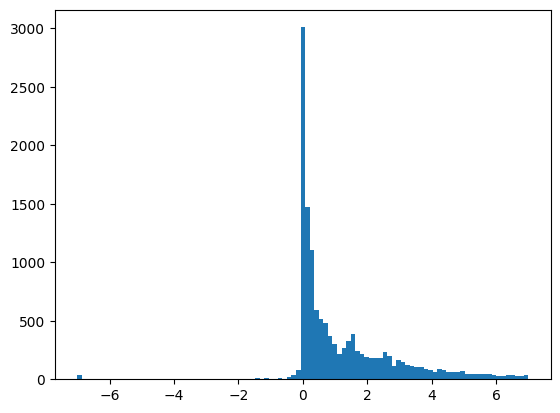

In [34]:
plt.hist(log_fvu_matrix.flatten(), bins=np.linspace(-7,7, 100));

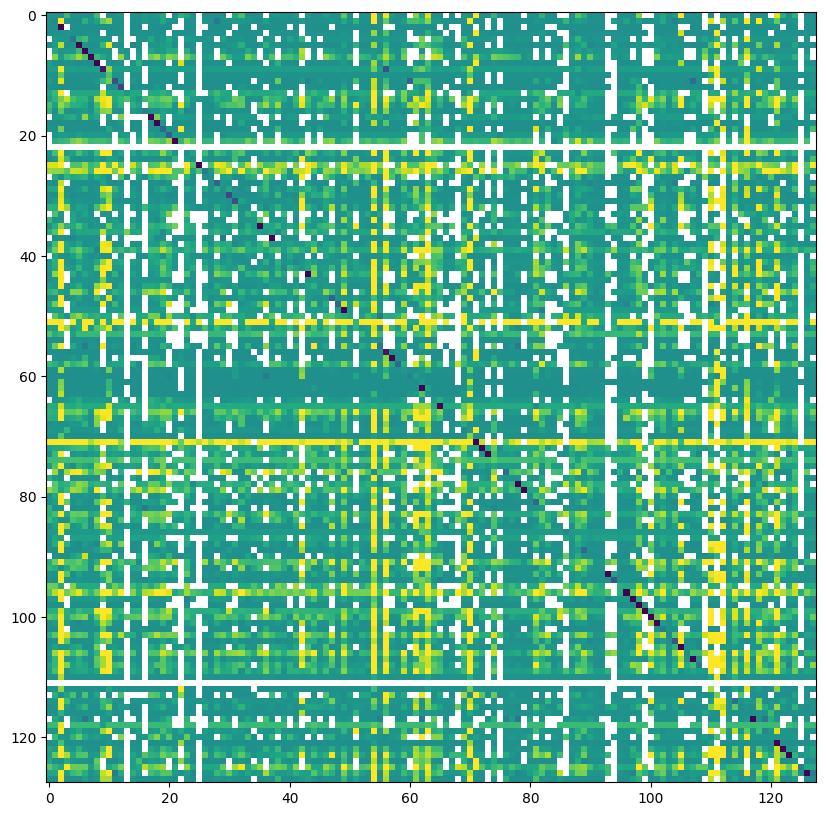

In [35]:
fig, ax = plt.subplots(figsize=(10, 10))

ax.imshow(log_fvu_matrix, cmap='viridis', interpolation='nearest', vmin=-7, vmax=7)

In [ ]:
def log_fvu_to_target_cosine_similarity(log_fvu_matrix, min_fvu, max_fvu):
    """
    Convert log FVU values to cosine similarity scores.
    """
    # Normalize the log FVU values to a range of [0, 1]
    normalized_fvu = (log_fvu_matrix - min_fvu) / (max_fvu - min_fvu)
    
    # Convert to cosine similarity
    cosine_similarity = 1 - normalized_fvu
    
    return cosine_similarity

In [38]:
cosine_similarity_matrix = log_fvu_to_target_cosine_similarity(log_fvu_matrix, -7, 7)

In [41]:
# Nan means no constants could be found to fit the data, so the skeletons must be very different
cosine_similarity_matrix[~torch.isfinite(cosine_similarity_matrix)] = -1

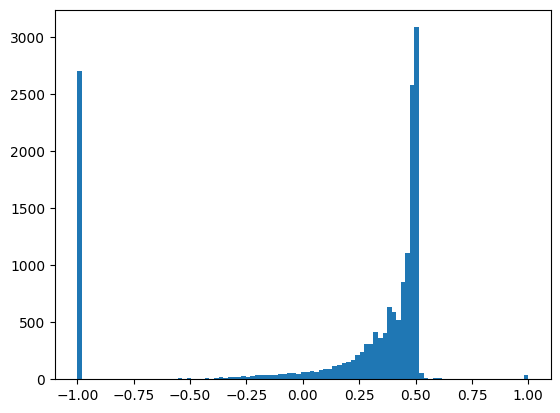

In [45]:
plt.hist(cosine_similarity_matrix.flatten(), bins=np.linspace(-1, 1, 100));

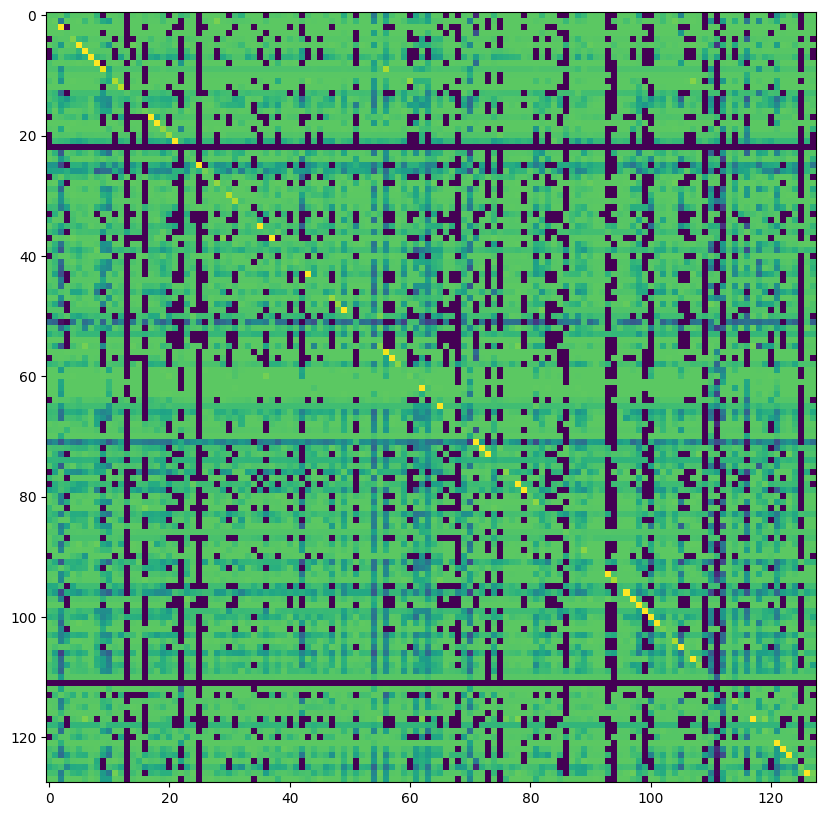

In [43]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(cosine_similarity_matrix, cmap='viridis', interpolation='nearest', vmin=-1, vmax=1)

In [ ]:
from torch import nn

class CosineSimilarityLogFVUMatchLoss(nn.Module):
    def __init__(self, n_samples: int | None = 1):
        super().__init__()
        self.n_samples = n_samples

    def forward(self, x_target: torch.Tensor, y_target: torch.Tensor, candidate_skeletons: list[list[str]], embeddings: torch.Tensor) -> torch.Tensor:
        """
        Compute the cosine similarity between the log FVU values of the target and the candidate skeletons.
        """
        # Get the number of samples
        if self.n_samples is None:
            n_samples = x_target.shape[0]
        else:
            n_samples = self.n_samples

        # Compute the log FVU values
        log_fvu_matrix = torch.zeros((n_samples, len(candidate_skeletons)), dtype=torch.float32)
        for i in range(n_samples):
            for j in range(len(candidate_skeletons)):
                log_fvu_matrix[i, j] = log_FVU(x_target[i], y_target[i], candidate_skeletons[j])

        # Convert to cosine similarity
        target_cosine_similarity_matrix = log_fvu_to_target_cosine_similarity(log_fvu_matrix, -7, 7)

        # Nan means no constants could be found to fit the data, so the skeletons must be very different
        target_cosine_similarity_matrix[~torch.isfinite(target_cosine_similarity_matrix)] = -1
        
        # Compute the cosine similarity between the actual embeddings
        cosine_similarity_matrix = torch.nn.functional.cosine_similarity(embeddings.unsqueeze(1), embeddings.unsqueeze(0), dim=-1)

        # Compute the loss
        loss = torch.nn.functional.mse_loss(cosine_similarity_matrix, target_cosine_similarity_matrix)
        return loss